# Project Benson

This notebook retrieves and wrangles MTA turnstile data. The data is parsed by station, date, and time. Additionally, zip code data was added from a csv generated by google_api_zipcode notebook. 


**We used MTA subway data to  identify stations and times for optimizing the placement of street team deployment**

- Fill the event space with individuals passionate about increasing the participation of women in technology

- Dispatch street teams at entrances to busy subway stations. 

- Collect email addresses and those who sign up are sent free tickets to the gala


### I. Import libraries

In [1]:
import pandas as pd
import numpy as np
import re
import urllib.request as request
import datetime
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from dateutil import parser

### II. Download MTA data 


#### Field description can be found from [here](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt.)

 
    Data is showing how many people entered every four hours (or every time that 'REGULAR' was written) and to probably ignore or sweep out the pieces of data with other words like 'LOGON' or 'DOORCLOSE'.


    Field Description : C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS


- C/A      = Control Area (A002) , control area is kind of like a 'station' for a specific line

- UNIT     = Remote Unit for a station (R051), remote unit is kind of like a 'booth' so the same station can have a couple booths, 

- SCP      = Subunit Channel Position represents an specific address for a device (02-00-00), the subunit channel position could represent a turnstile, but could also represent a collection of turnstiles (represents an specific address for a device)

- STATION  = Represents the station name the device is located at

- LINENAME = Represents all train lines that can be boarded at this station
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.

- DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
- DATE     = Represents the date (MM-DD-YY)
- TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
- DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
- ENTRIES  = The comulative entry register value for a device
- EXIST    = The cumulative exit register value for a device




### III. Load data into Pandas dataframe

In [2]:
import glob

files = glob.glob('./dataset/*.txt')
sorted(files)

['./dataset/turnstile_180630.txt',
 './dataset/turnstile_180707.txt',
 './dataset/turnstile_180714.txt',
 './dataset/turnstile_180721.txt',
 './dataset/turnstile_180728.txt',
 './dataset/turnstile_180804.txt',
 './dataset/turnstile_180811.txt',
 './dataset/turnstile_180818.txt',
 './dataset/turnstile_180825.txt',
 './dataset/turnstile_180901.txt',
 './dataset/turnstile_180908.txt',
 './dataset/turnstile_180915.txt',
 './dataset/turnstile_180922.txt',
 './dataset/turnstile_180929.txt',
 './dataset/turnstile_181006.txt',
 './dataset/turnstile_181013.txt',
 './dataset/turnstile_181020.txt',
 './dataset/turnstile_181027.txt',
 './dataset/turnstile_181103.txt',
 './dataset/turnstile_181110.txt',
 './dataset/turnstile_181117.txt',
 './dataset/turnstile_181124.txt',
 './dataset/turnstile_181201.txt',
 './dataset/turnstile_181208.txt',
 './dataset/turnstile_181215.txt',
 './dataset/turnstile_181222.txt',
 './dataset/turnstile_181229.txt',
 './dataset/turnstile_190105.txt',
 './dataset/turnstil

In [3]:
turnstiles_df = pd.concat([pd.read_csv(file) for file in files ], axis=0)

In [4]:
print(turnstiles_df.columns)

# remove space character in column names
#turnstiles_df.columns = turnstiles_df.columns.str.replace(' ','')
turnstiles_df.columns = turnstiles_df.columns.str.replace(' ','')
print(turnstiles_df.columns)
print(len(turnstiles_df))

#turnstiles_df.tail()
turnstiles_df.head()

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')
Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')
10661665


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/19/2019,03:00:00,REGULAR,6914752,2344809
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/19/2019,07:00:00,REGULAR,6914764,2344821
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/19/2019,11:00:00,REGULAR,6914825,2344898
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/19/2019,15:00:00,REGULAR,6915047,2344971
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/19/2019,19:00:00,REGULAR,6915367,2345026


### IV. Save dataframe into pickle file

In [5]:
#turnstiles_df.to_csv('mta_2018.csv', sep=',')
turnstiles_df.to_pickle('mta_2018.pkl')

In [6]:
!ls 

commute.csv             mta_2018.csv            survey_data_ny.zip
dataset                 mta_2018.pkl            top_100_stations.pkl
example.png             plot_top_stations.ipynb zipcodes.csv
google_places_api.ipynb project1_mta.ipynb      zipcodes.pkl
household_income.csv    survey_data.ipynb


In [7]:
# Three weeks of data
turnstiles_df.DATE.value_counts().sort_index()

01/01/2019    28742
01/02/2019    28691
01/03/2019    28584
01/04/2019    29388
01/05/2019    28619
01/06/2019    28662
01/07/2019    28627
01/08/2019    29035
01/09/2019    28820
01/10/2019    28880
01/11/2019    28447
01/12/2019    28685
01/13/2019    28692
01/14/2019    28910
01/15/2019    29509
01/16/2019    30446
01/17/2019    29140
01/18/2019    29345
01/19/2019    28727
01/20/2019    28689
01/21/2019    28682
01/22/2019    28801
01/23/2019    28855
01/24/2019    28607
01/25/2019    29238
01/26/2019    28757
01/27/2019    28792
01/28/2019    29049
01/29/2019    29103
01/30/2019    29285
              ...  
12/02/2018    28507
12/03/2018    28423
12/04/2018    28992
12/05/2018    29252
12/06/2018    28571
12/07/2018    29437
12/08/2018    28400
12/09/2018    28322
12/10/2018    29942
12/11/2018    28532
12/12/2018    28668
12/13/2018    28560
12/14/2018    28438
12/15/2018    28411
12/16/2018    28390
12/17/2018    29300
12/18/2018    29256
12/19/2018    28865
12/20/2018    28480


In [8]:
mask = ((turnstiles_df["C/A"] == "A002") & 
        (turnstiles_df["UNIT"] == "R051") & 
        (turnstiles_df["SCP"] == "02-00-00") & 
        (turnstiles_df["STATION"] == "59 ST"))

mask[:10]

0    True
1    True
2    True
3    True
4    True
5    True
6    True
7    True
8    True
9    True
dtype: bool

In [9]:
mask = ((turnstiles_df["C/A"] == "A002") & 
        (turnstiles_df["UNIT"] == "R051") & 
        (turnstiles_df["SCP"] == "02-00-00") & 
        (turnstiles_df["STATION"] == "59 ST"))

turnstiles_df[mask].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/19/2019,03:00:00,REGULAR,6914752,2344809
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/19/2019,07:00:00,REGULAR,6914764,2344821
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/19/2019,11:00:00,REGULAR,6914825,2344898
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/19/2019,15:00:00,REGULAR,6915047,2344971
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/19/2019,19:00:00,REGULAR,6915367,2345026


### V. Create datetime column and sort dataframe by datetime

In [10]:
# Take the date and time fields into a single datetime column
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, format="%m/%d/%Y %H:%M:%S")

In [11]:
turnstiles_df = turnstiles_df.sort_values(['DATE_TIME'])

###  VI. Sanity check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME", "ENTRIES" is unique


In [12]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])  
 .ENTRIES.count()).reset_index().sort_values(['ENTRIES'], ascending=False)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
4157042,N311,R339,01-00-02,36 ST,2018-12-09 16:00:00,2
8706740,R283,R221,00-00-03,167 ST,2019-04-15 12:00:00,2
4159273,N311,R339,01-06-00,36 ST,2018-12-10 08:00:00,2
282173,A035,R170,00-00-00,14 ST-UNION SQ,2019-03-27 17:00:00,2
4159270,N311,R339,01-06-00,36 ST,2018-12-10 00:00:00,2
4159269,N311,R339,01-06-00,36 ST,2018-12-09 20:00:00,2
4159268,N311,R339,01-06-00,36 ST,2018-12-09 16:00:00,2
2127869,JFK03,R536,00-03-02,JFK JAMAICA CT1,2018-12-01 12:00:00,2
5292536,N525,R142,01-00-04,DELANCEY/ESSEX,2019-05-11 05:00:00,2
8706744,R283,R221,00-00-03,167 ST,2019-04-16 04:00:00,2


In [13]:
# On 2018/12/9, we seem to have two entries for same time.  Let's take a look
mask = ((turnstiles_df["C/A"] == "N311") & 
(turnstiles_df["UNIT"] == "R339") & 
(turnstiles_df["SCP"] == "01-00-02") & 
(turnstiles_df["STATION"] == "36 ST") &
(turnstiles_df["DATE_TIME"].dt.date == datetime.datetime(2018, 12, 9).date()))

turnstiles_df[mask]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
78353,N311,R339,01-00-02,36 ST,MR,IND,12/09/2018,00:00:00,REGULAR,282721,1444010,2018-12-09 00:00:00
78354,N311,R339,01-00-02,36 ST,MR,IND,12/09/2018,04:00:00,REGULAR,282721,1444026,2018-12-09 04:00:00
78355,N311,R339,01-00-02,36 ST,MR,IND,12/09/2018,08:00:00,REGULAR,282721,1444049,2018-12-09 08:00:00
78356,N311,R339,01-00-02,36 ST,MR,IND,12/09/2018,12:00:00,RECOVR AUD,282722,1444088,2018-12-09 12:00:00
78357,N311,R339,01-00-02,36 ST,MR,IND,12/09/2018,16:00:00,REGULAR,282726,1444160,2018-12-09 16:00:00
78358,N311,R339,01-00-02,36 ST,MR,IND,12/09/2018,16:00:00,RECOVR AUD,814900,454218,2018-12-09 16:00:00
78360,N311,R339,01-00-02,36 ST,MR,IND,12/09/2018,20:00:00,RECOVR AUD,815015,454259,2018-12-09 20:00:00
78359,N311,R339,01-00-02,36 ST,MR,IND,12/09/2018,20:00:00,REGULAR,282734,1444243,2018-12-09 20:00:00


In [14]:
turnstiles_df.DESC.value_counts()

REGULAR       10615243
RECOVR AUD       46422
Name: DESC, dtype: int64

In [15]:
# Get rid of the duplicate entry
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)

In [16]:
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [17]:
# Sanity check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2018-06-23 00:00:00,1
7107673,R142,R293,01-00-00,34 ST-PENN STA,2018-11-02 10:00:00,1
7107655,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 02:00:00,1
7107656,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 06:00:00,1
7107657,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 10:00:00,1


### VII. Sanity check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME", "EXITS" is unique

In [18]:
(turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])\
 .EXITS.count()).reset_index().sort_values(['EXITS'], ascending=False)

,C/A,UNIT,SCP,STATION,DATE_TIME,EXITS
0,A002,R051,02-00-00,59 ST,2018-06-23 00:00:00,1
7107673,R142,R293,01-00-00,34 ST-PENN STA,2018-11-02 10:00:00,1
7107655,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 02:00:00,1
7107656,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 06:00:00,1
7107657,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 10:00:00,1
7107658,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 14:00:00,1
7107659,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 18:00:00,1
7107660,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 18:22:37,1
7107661,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 18:23:57,1
7107662,R142,R293,01-00-00,34 ST-PENN STA,2018-10-31 18:25:17,1


In [19]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])  
 .EXITS.count()).reset_index().sort_values(['EXITS'], ascending=False)['EXITS'].unique()

array([1])

### VIII. Dataframe for hourly traffic

In [162]:
turnstiles_hourly = turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "TIME"])\
['ENTRIES', 'EXITS'].first().reset_index()



turnstiles_hourly[["PREV_TIME", "PREV_ENTRIES", "PREV_EXITS"]] = (turnstiles_hourly
                                                                  .groupby(["C/A", "UNIT", "SCP", "STATION"])\
                                                                  ["TIME", "ENTRIES", "EXITS"]
                                                                  .transform(lambda grp: grp.shift(1)))


turnstiles_hourly.head()

,C/A,UNIT,SCP,STATION,TIME,ENTRIES,EXITS,PREV_TIME,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,00:00:00,7115170,2409710,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,03:00:00,6972000,2365115,00:00:00,7115170.0,2409710.0
2,A002,R051,02-00-00,59 ST,04:00:00,7115183,2409715,03:00:00,6972000.0,2365115.0
3,A002,R051,02-00-00,59 ST,07:00:00,6972010,2365118,04:00:00,7115183.0,2409715.0
4,A002,R051,02-00-00,59 ST,07:26:01,6764512,2293206,07:00:00,6972010.0,2365118.0


In [163]:
# let's check that the number of entries for today is higher than entries for yesterday
turnstiles_hourly[(turnstiles_hourly["ENTRIES"] < turnstiles_hourly["PREV_ENTRIES"])\
                  & (turnstiles_hourly["EXITS"] < turnstiles_hourly["PREV_EXITS"])].head()

,C/A,UNIT,SCP,STATION,TIME,ENTRIES,EXITS,PREV_TIME,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,03:00:00,6972000,2365115,00:00:00,7115170.0,2409710.0
3,A002,R051,02-00-00,59 ST,07:00:00,6972010,2365118,04:00:00,7115183.0,2409715.0
4,A002,R051,02-00-00,59 ST,07:26:01,6764512,2293206,07:00:00,6972010.0,2365118.0
6,A002,R051,02-00-00,59 ST,08:02:42,6933669,2351446,08:00:00,7115223.0,2409792.0
10,A002,R051,02-00-00,59 ST,08:43:56,6808891,2308941,08:30:55,7054815.0,2391066.0


In [164]:
# Let's see how many stations have this problem

(turnstiles_hourly[(turnstiles_hourly["ENTRIES"] < turnstiles_hourly["PREV_ENTRIES"])\
                  & (turnstiles_hourly["EXITS"] < turnstiles_hourly["PREV_EXITS"])]\
 .groupby(["C/A", "UNIT", "SCP", "STATION"]).size()) # size() behaves same as if we'd done .DATE.count()

C/A    UNIT  SCP       STATION      
A002   R051  02-00-00  59 ST            15
             02-00-01  59 ST            15
             02-03-00  59 ST            15
             02-03-01  59 ST            15
             02-03-02  59 ST            15
             02-03-03  59 ST            15
             02-03-04  59 ST            15
             02-03-05  59 ST            15
             02-03-06  59 ST            15
             02-06-00  59 ST            15
A006   R079  00-00-00  5 AV/59 ST       21
             00-00-01  5 AV/59 ST       21
             00-00-02  5 AV/59 ST       21
             00-00-03  5 AV/59 ST       21
             00-00-04  5 AV/59 ST       21
             00-03-00  5 AV/59 ST       21
             00-03-01  5 AV/59 ST       19
             00-03-02  5 AV/59 ST       21
A007   R079  01-06-00  5 AV/59 ST       16
             01-06-01  5 AV/59 ST       16
             01-06-02  5 AV/59 ST       16
             01-06-03  5 AV/59 ST       16
A010   R080  00-0

In [165]:
def get_hourly_counts(row, max_counter, type_count=None):
    
    if type_count == 'ENTRY':
        counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    elif type_count == 'EXIT':
        counter = row["EXITS"] - row["PREV_EXITS"]
        
    if counter < 0:
        return 0
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

# If counter is > 1 million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
turnstiles_hourly["HOURLY_ENTRIES"] = turnstiles_hourly.apply(get_hourly_counts, axis=1, \
                                                              max_counter=5000, type_count='ENTRY') 

turnstiles_hourly["HOURLY_EXITS"] = turnstiles_hourly.apply(get_hourly_counts, axis=1, \
                                                            max_counter=5000, type_count='EXIT')

In [166]:
# get total hourly traffic 
turnstiles_hourly["HOURLY_TRAFFIC"] = turnstiles_hourly["HOURLY_ENTRIES"] + turnstiles_hourly["HOURLY_EXITS"]

#turnstiles_hourly = turnstiles_hourly.sort_values(['TIME'])
turnstiles_hourly.describe()

,ENTRIES,EXITS,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS,HOURLY_TRAFFIC
count,5.800110e+05,5.800110e+05,5.749870e+05,5.749870e+05,574987.000000,574987.000000,574987.000000
mean,1.376818e+07,1.157912e+07,1.352962e+07,1.139389e+07,108.844576,167.482651,276.327227
std,1.220322e+08,1.141207e+08,1.209314e+08,1.132344e+08,575.285574,691.581162,950.965091
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000
25%,2.812600e+04,1.933400e+04,2.777600e+04,1.919900e+04,0.000000,0.000000,0.000000
50%,2.036990e+05,1.773990e+05,2.006340e+05,1.741090e+05,0.000000,0.000000,0.000000
75%,1.240928e+06,9.337430e+05,1.208572e+06,9.156470e+05,0.000000,0.000000,0.000000
max,2.129834e+09,2.146093e+09,2.129834e+09,2.146093e+09,5000.000000,5000.000000,9848.000000


In [167]:
turnstiles_hourly['TIME'] = turnstiles_hourly['TIME'].apply(lambda x: datetime.datetime.strptime(x, '%H:%M:%S'))
turnstiles_hourly.head()

,C/A,UNIT,SCP,STATION,TIME,ENTRIES,EXITS,PREV_TIME,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS,HOURLY_TRAFFIC
0,A002,R051,02-00-00,59 ST,1900-01-01 00:00:00,7115170,2409710,NaN,NaN,NaN,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,1900-01-01 03:00:00,6972000,2365115,00:00:00,7115170.0,2409710.0,0.0,0.0,0.0
2,A002,R051,02-00-00,59 ST,1900-01-01 04:00:00,7115183,2409715,03:00:00,6972000.0,2365115.0,0.0,0.0,0.0
3,A002,R051,02-00-00,59 ST,1900-01-01 07:00:00,6972010,2365118,04:00:00,7115183.0,2409715.0,0.0,0.0,0.0
4,A002,R051,02-00-00,59 ST,1900-01-01 07:26:01,6764512,2293206,07:00:00,6972010.0,2365118.0,0.0,0.0,0.0


In [168]:
def hour_label(hour):
    hour_range = {'0-4' : range(0, 4), 
                  '4-8' : range(4, 8), 
                  '8-12': range(8, 12), 
                  '12-16': range(12, 16), 
                  '16-20': range(16, 20),
                  '20-24': range(20, 24)}

    return [k for k, v in hour_range.items() if hour in v][0]



hour_label(13), hour_label( turnstiles_hourly['TIME'][100000].hour )

('12-16', '8-12')

In [169]:
turnstiles_hourly['TIME_RANGE'] = turnstiles_hourly['TIME'].apply(lambda x: hour_label(x.hour) )
turnstiles_hourly.head()

,C/A,UNIT,SCP,STATION,TIME,ENTRIES,EXITS,PREV_TIME,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS,HOURLY_TRAFFIC,TIME_RANGE
0,A002,R051,02-00-00,59 ST,1900-01-01 00:00:00,7115170,2409710,NaN,NaN,NaN,NaN,NaN,NaN,0-4
1,A002,R051,02-00-00,59 ST,1900-01-01 03:00:00,6972000,2365115,00:00:00,7115170.0,2409710.0,0.0,0.0,0.0,0-4
2,A002,R051,02-00-00,59 ST,1900-01-01 04:00:00,7115183,2409715,03:00:00,6972000.0,2365115.0,0.0,0.0,0.0,4-8
3,A002,R051,02-00-00,59 ST,1900-01-01 07:00:00,6972010,2365118,04:00:00,7115183.0,2409715.0,0.0,0.0,0.0,4-8
4,A002,R051,02-00-00,59 ST,1900-01-01 07:26:01,6764512,2293206,07:00:00,6972010.0,2365118.0,0.0,0.0,0.0,4-8


In [170]:
# remove nan row 
turnstiles_hourly = turnstiles_hourly.dropna()
turnstiles_hourly.head()

,C/A,UNIT,SCP,STATION,TIME,ENTRIES,EXITS,PREV_TIME,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS,HOURLY_TRAFFIC,TIME_RANGE
1,A002,R051,02-00-00,59 ST,1900-01-01 03:00:00,6972000,2365115,00:00:00,7115170.0,2409710.0,0.0,0.0,0.0,0-4
2,A002,R051,02-00-00,59 ST,1900-01-01 04:00:00,7115183,2409715,03:00:00,6972000.0,2365115.0,0.0,0.0,0.0,4-8
3,A002,R051,02-00-00,59 ST,1900-01-01 07:00:00,6972010,2365118,04:00:00,7115183.0,2409715.0,0.0,0.0,0.0,4-8
4,A002,R051,02-00-00,59 ST,1900-01-01 07:26:01,6764512,2293206,07:00:00,6972010.0,2365118.0,0.0,0.0,0.0,4-8
5,A002,R051,02-00-00,59 ST,1900-01-01 08:00:00,7115223,2409792,07:26:01,6764512.0,2293206.0,0.0,0.0,0.0,8-12


In [171]:
turnstiles_hourly.to_pickle('hourly_ridership.pkl')

### IX. Find the top 100 busiest stations by hour

In [184]:
# hour traffic for a year
station_turnstiles_hourly = turnstiles_hourly.groupby(['STATION', 'TIME_RANGE'])['HOURLY_TRAFFIC'].sum().reset_index()

In [185]:
station_turnstiles_hourly.to_pickle('hourly_ridership.pkl')

In [175]:
station_turnstiles_hourly = station_turnstiles_hourly.sort_values(['HOURLY_TRAFFIC', 'TIME_RANGE', 'STATION'], \
                                                                  ascending=False)
stations = np.unique(station_turnstiles_hourly['STATION'][:100])
stations

array(['14TH STREET', '34 ST-HERALD SQ', '34 ST-HUDSON YD',
       '34 ST-PENN STA', '47-50 STS ROCK', '86 ST', '9TH STREET',
       'CHAMBERS ST', 'CITY / BUS', 'CORTLANDT ST', 'EXCHANGE PLACE',
       'FULTON ST', 'GRD CNTRL-42 ST', 'GROVE STREET', 'HARRISON',
       'JOURNAL SQUARE', 'LACKAWANNA', 'NEWARK BM BW', 'NEWARK C',
       'NEWARK HM HE', 'NEWARK HW BMEBE', 'PATH NEW WTC', 'THIRTY ST',
       'TWENTY THIRD ST', 'WALL ST'], dtype=object)

In [182]:
top_station_turnstiles_hourly = station_turnstiles_hourly.groupby(['STATION','TIME_RANGE'])\
['HOURLY_TRAFFIC'].sum().reset_index()
top_station_turnstiles_hourly = top_station_turnstiles_hourly.sort_values(['HOURLY_TRAFFIC'], ascending=False)

In [183]:
top_station_turnstiles_hourly

,STATION,TIME_RANGE,HOURLY_TRAFFIC
1793,NEWARK BM BW,8-12,2608475.0
1798,NEWARK C,4-8,2558413.0
1792,NEWARK BM BW,4-8,2553608.0
1795,NEWARK C,12-16,2530741.0
1790,NEWARK BM BW,16-20,2529402.0
1799,NEWARK C,8-12,2527907.0
1796,NEWARK C,16-20,2527371.0
1789,NEWARK BM BW,12-16,2524352.0
1788,NEWARK BM BW,0-4,2516451.0
1797,NEWARK C,20-24,2514479.0


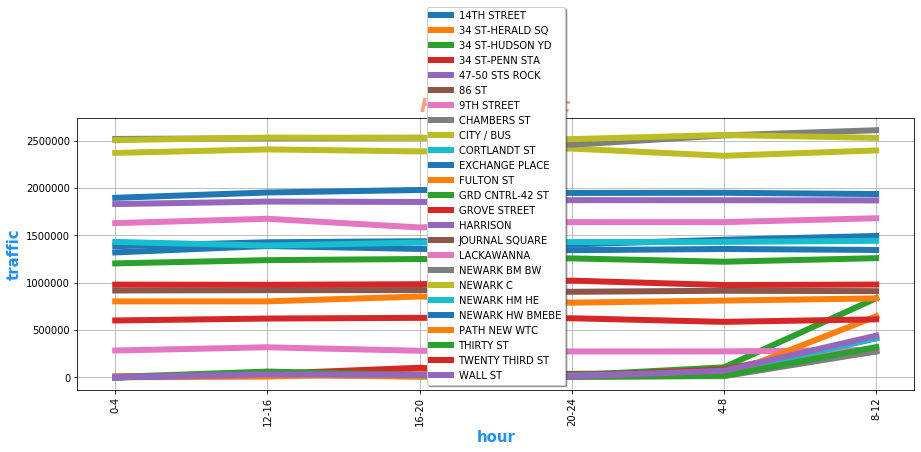

In [186]:
def plot_hourly_traffic(df, stations, color ='#9ACD32'):
    
    plt.figure(figsize=(15,5))
    
    for station in stations:
        hour_range = df[df['STATION'] == station]['TIME_RANGE']
        traffic = df[df['STATION'] == station]['HOURLY_TRAFFIC']
        plt.plot(hour_range,traffic, linestyle='-', linewidth=6) #color = color
    
    
    plt.grid()
    plt.title('Hourly traffic',fontsize = 20,style='italic',weight='bold',color='#FFA07A')

    plt.legend(stations, shadow=True)
    plt.xticks(rotation=90)
    plt.xlabel('hour', fontsize = 15,weight = 'bold',color='#1E90FF')
    plt.ylabel('traffic',fontsize = 15, weight = 'bold',color='#1E90FF')
    


#test = station_turnstiles_hourly[station_turnstiles_hourly['STATION'] == 'PAVONIA/NEWPORT']

#hour_range, traffic = test['TIME_RANGE'], test['HOURLY_TRAFFIC']

plot_hourly_traffic(station_turnstiles_hourly, stations)

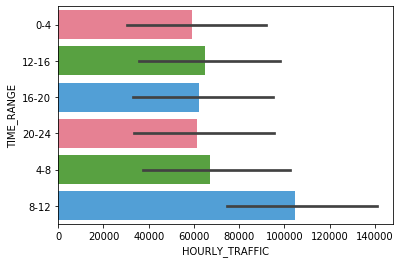

In [187]:
import seaborn as sns

sns.barplot(x='HOURLY_TRAFFIC',y = 'TIME_RANGE',data=station_turnstiles_hourly,palette = sns.color_palette("husl", 3));

### X. Dataframe for daily traffic

In [37]:
turnstiles_daily = turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"])\
['ENTRIES', 'EXITS'].first().reset_index()


turnstiles_daily[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (turnstiles_daily
                                                                 .groupby(["C/A", "UNIT", "SCP", "STATION"])\
                                                                 ["DATE", "ENTRIES", "EXITS"]
                                                                 .transform(lambda grp: grp.shift(1)))

turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,01/01/2019,6892430,2336890,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,01/02/2019,6893894,2337403,01/01/2019,6892430.0,2336890.0
2,A002,R051,02-00-00,59 ST,01/03/2019,6895434,2337911,01/02/2019,6893894.0,2337403.0
3,A002,R051,02-00-00,59 ST,01/04/2019,6896974,2338463,01/03/2019,6895434.0,2337911.0
4,A002,R051,02-00-00,59 ST,01/05/2019,6897740,2338703,01/04/2019,6896974.0,2338463.0


In [38]:
# let's check that the number of entries for today is higher than entries for yesterday
turnstiles_daily[(turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]) \
                 & (turnstiles_daily["EXITS"] < turnstiles_daily["PREV_EXITS"])].head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
173,A002,R051,02-00-00,59 ST,06/23/2018,6667819,2260112,06/22/2019,7108333.0,2407608.0
175,A002,R051,02-00-00,59 ST,06/24/2018,6668489,2260325,06/23/2019,7108973.0,2407775.0
177,A002,R051,02-00-00,59 ST,06/25/2018,6669771,2260811,06/24/2019,7110324.0,2408207.0
179,A002,R051,02-00-00,59 ST,06/26/2018,6671070,2261322,06/25/2019,7111785.0,2408693.0
181,A002,R051,02-00-00,59 ST,06/27/2018,6672463,2261842,06/26/2019,7113402.0,2409210.0


In [39]:
# Let's see how many stations have this problem
(turnstiles_daily[(turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"])\
                  & (turnstiles_daily["EXITS"] < turnstiles_daily["PREV_EXITS"])]\
 .groupby(["C/A", "UNIT", "SCP", "STATION"]).size()) # size() behaves same as if we'd done .DATE.count() 

C/A    UNIT  SCP       STATION      
A002   R051  02-00-00  59 ST             7
             02-00-01  59 ST             7
             02-03-00  59 ST             7
             02-03-01  59 ST             7
             02-03-02  59 ST             7
             02-03-03  59 ST             7
             02-03-04  59 ST             7
             02-03-05  59 ST             7
             02-03-06  59 ST             7
             02-06-00  59 ST             8
A006   R079  00-00-00  5 AV/59 ST        7
             00-00-01  5 AV/59 ST        7
             00-00-02  5 AV/59 ST        7
             00-00-03  5 AV/59 ST        7
             00-00-04  5 AV/59 ST        7
             00-03-00  5 AV/59 ST        7
             00-03-01  5 AV/59 ST       11
             00-03-02  5 AV/59 ST        7
A007   R079  01-06-00  5 AV/59 ST        7
             01-06-01  5 AV/59 ST        7
             01-06-02  5 AV/59 ST        7
             01-06-03  5 AV/59 ST        7
A010   R080  00-0

In [85]:
def get_daily_counts(row, max_counter, type_count=None):
    
    
    if type_count == 'ENTRY':
        counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    elif type_count == 'EXIT':
        counter = row["EXITS"] - row["PREV_EXITS"]
        
    if counter < 0:
        return 0 
    if counter > max_counter:
        #print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

# If counter is > 1 million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=80000, type_count='ENTRY') 
turnstiles_daily["DAILY_EXITS"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=80000, type_count='EXIT')

In [86]:
turnstiles_daily["DAILY_TRAFFIC"] = turnstiles_daily["DAILY_ENTRIES"] + turnstiles_daily["DAILY_EXITS"]

In [87]:
#turnstiles_daily['DATE'] = turnstiles_daily['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
turnstiles_daily['DATE'] = pd.to_datetime(turnstiles_daily['DATE'])
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_TRAFFIC
953277,N606,R025,00-00-07,JAMAICA CENTER,2018-06-23,25859830,4125861,06/22/2019,27470693.0,4428908.0,0.0,0.0,0.0
730728,N331,R219,00-00-03,67 AV,2018-06-23,5003246,3567833,06/22/2019,5587258.0,3827025.0,0.0,0.0,0.0
1072669,PTH19,R549,02-02-04,NEWARK C,2018-06-23,55941,4453,06/22/2019,1710.0,254.0,54231.0,4199.0,58430.0
1001122,PTH04,R551,00-01-00,GROVE STREET,2018-06-23,7757,4572,06/22/2019,6413.0,5109.0,1344.0,0.0,1344.0
463252,N071,R013,00-00-02,34 ST-PENN STA,2018-06-23,2850728,4216570,06/22/2019,3124633.0,4583260.0,0.0,0.0,0.0


In [88]:
turnstiles_daily = turnstiles_daily.sort_values(['DATE'], ascending=True)
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS,DAILY_TRAFFIC
953277,N606,R025,00-00-07,JAMAICA CENTER,2018-06-23,25859830,4125861,06/22/2019,27470693.0,4428908.0,0.0,0.0,0.0
949569,N605,R024,00-06-01,SUTPHIN-ARCHER,2018-06-23,1075756,367301,06/22/2019,1746303.0,760540.0,0.0,0.0,0.0
1252444,R175,R169,01-00-00,137 ST CITY COL,2018-06-23,2714842,16068750,06/22/2019,54120.0,337813.0,0.0,0.0,0.0
594319,N181A,R464,00-05-01,AQUEDUCT RACETR,2018-06-23,1,190,06/22/2019,1.0,197.0,0.0,0.0,0.0
1587908,R515,R095,00-00-00,ASTORIA DITMARS,2018-06-23,3144292,6327392,06/22/2019,457344.0,606610.0,0.0,0.0,0.0


In [89]:
turnstiles_daily["DAILY_TRAFFIC"].describe()

count    1.761916e+06
mean     1.914893e+03
std      3.573438e+03
min      0.000000e+00
25%      4.680000e+02
50%      1.390000e+03
75%      2.622000e+03
max      1.497190e+05
Name: DAILY_TRAFFIC, dtype: float64

In [90]:
station_turnstiles_daily = turnstiles_daily.groupby(["STATION", "DATE"])["DAILY_TRAFFIC"].sum().reset_index()
station_turnstiles_daily.head()

,STATION,DATE,DAILY_TRAFFIC
0,1 AV,2018-06-23,0.0
1,1 AV,2018-06-24,0.0
2,1 AV,2018-06-25,0.0
3,1 AV,2018-06-26,0.0
4,1 AV,2018-06-27,0.0


In [91]:
station_turnstiles_daily["DAILY_TRAFFIC"].describe()

count    1.393620e+05
mean     2.420948e+04
std      4.365796e+04
min      0.000000e+00
25%      5.592250e+03
50%      1.144000e+04
75%      2.497375e+04
max      1.366225e+06
Name: DAILY_TRAFFIC, dtype: float64

In [105]:
# check data outliers
station_turnstiles_daily[station_turnstiles_daily["DAILY_TRAFFIC"] > 5e5]

,STATION,DATE,DAILY_TRAFFIC
8150,161/YANKEE STAD,2019-06-23,1170371.0
8151,161/YANKEE STAD,2019-06-24,1170362.0
8152,161/YANKEE STAD,2019-06-25,1181948.0
8153,161/YANKEE STAD,2019-06-26,1199634.0
8154,161/YANKEE STAD,2019-06-27,1199574.0
8155,161/YANKEE STAD,2019-06-28,1198681.0
21882,34 ST-HERALD SQ,2019-03-05,527408.0
22669,34 ST-PENN STA,2019-04-19,543993.0
45992,ATL AV-BARCLAY,2019-06-23,639805.0
45993,ATL AV-BARCLAY,2019-06-24,641428.0


In [107]:
# reduce the outlier , we filter out any row with daily traffic over 500000 
station_turnstiles_daily = station_turnstiles_daily[station_turnstiles_daily["DAILY_TRAFFIC"] < 5e5]

In [108]:
station_turnstiles_daily["DAILY_TRAFFIC"].describe()

count    139274.000000
mean      23707.934999
std       38240.013020
min           0.000000
25%        5589.000000
50%       11430.500000
75%       24934.000000
max      469318.000000
Name: DAILY_TRAFFIC, dtype: float64

In [109]:
def plot_daily_entries(date, counts, color ='#9ACD32', title=None):
    
    plt.figure(figsize=(15,5))
    plt.plot(dates,counts, linestyle='-', linewidth=6, color = color)
    plt.grid()
    plt.title('Daily entries',fontsize = 20,style='italic',weight='bold',color='#FFA07A')

    plt.legend([title], shadow=True)
    plt.xticks(rotation=90)
    plt.xlabel('datetime', fontsize = 15,weight = 'bold',color='#1E90FF')
    plt.ylabel('traffic',fontsize = 15, weight = 'bold',color='#1E90FF')

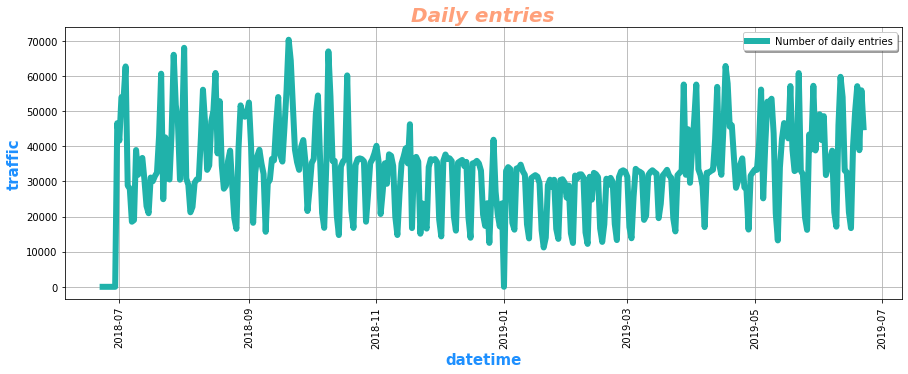

In [110]:
mask = ((station_turnstiles_daily["STATION"] == '161/YANKEE STAD'))


dates = station_turnstiles_daily[mask]['DATE']
counts = station_turnstiles_daily[mask]['DAILY_TRAFFIC']
plot_daily_entries(dates, counts, color = '#20B2AA', title='Number of daily entries')

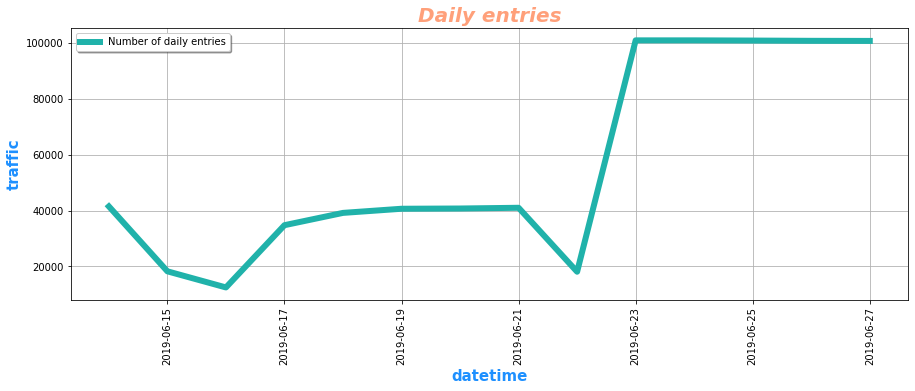

In [111]:
mask = ((station_turnstiles_daily["STATION"] == '1 AV'))


dates = station_turnstiles_daily[mask]['DATE'][-15:-1]
counts = station_turnstiles_daily[mask]['DAILY_TRAFFIC'][-15:-1]
plot_daily_entries(dates, counts, color = '#20B2AA', title='Number of daily entries')

In [112]:
mask = ((station_turnstiles_daily["DAILY_TRAFFIC"] >500000)) 
station_turnstiles_daily[mask]

,STATION,DATE,DAILY_TRAFFIC


In [113]:
station_turnstiles_daily['WEEKDAY'] = station_turnstiles_daily['DATE'].apply( lambda x: x.strftime('%A'))
station_turnstiles_daily['WEEK'] = station_turnstiles_daily['DATE'].dt.week
print(station_turnstiles_daily['WEEK'].unique())

[25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20
 21 22 23 24]


In [125]:
station_turnstiles_daily = station_turnstiles_daily[~station_turnstiles_daily['WEEKDAY'].isin(['Saturday', 'Sunday'])]

In [189]:
station_turnstiles_daily.to_pickle('daily_ridership.pkl')

### XI. Top 100 busiest stations in NYC

In [127]:
total_turnstiles = station_turnstiles_daily.groupby(['STATION'])['DAILY_TRAFFIC'].sum().reset_index()
top_stations = total_turnstiles.sort_values('DAILY_TRAFFIC', ascending=False)[:100]
top_stations[:20]

,STATION,DAILY_TRAFFIC
61,34 ST-PENN STA,81031625.0
233,GRD CNTRL-42 ST,74387325.0
59,34 ST-HERALD SQ,58803013.0
353,TIMES SQ-42 ST,49815477.0
46,23 ST,49153788.0
14,14 ST-UNION SQ,48370841.0
226,FULTON ST,45632088.0
68,42 ST-PORT AUTH,42732118.0
110,86 ST,40775869.0
9,125 ST,33842007.0


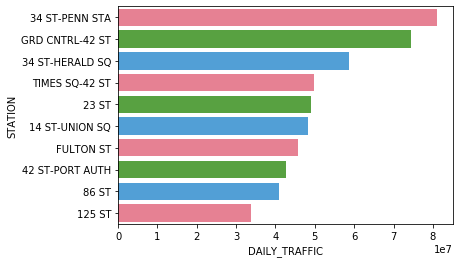

In [128]:
import seaborn as sns

sns.barplot(x='DAILY_TRAFFIC',y = 'STATION',data=top_stations[:10],palette = sns.color_palette("husl", 3));

In [129]:
top_stations.to_pickle('top_100_stations.pkl')